In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from ISLP import confusion_table

In [2]:
df = pd.read_excel("tesdata.xlsx")
#get only data where diabetes is a clear yes or no, no prediabetes, no null rows
df = df[df['DIABETE4'].isin([1,3])]

# Data Cleaning/Feature Engineering

**Map to a format that makes sense for python models**

Original file was an SAS file. This means the majority of it was in a format which labele 1 as yes, 2 as no, and sometimes had numbers such as 7,9, or 99 represent 'other/no response'. Simple binary values or values whose scale is logical mathematically work better for regression models and such

In [3]:
#define maps for different columns based on their SAS formats

#if the person had one or more docs, say they had one, set to 1
#if they had no doc, set to 0
#else, return null so value can be imputed later
def simplify_doc(x):
    if x == 1 or x==2:
        return 1
    elif x == 3:
        return 0
    else:
        return None
    
#default map for all simple columns
#1 for yes, 0 for no, None for null/missing to impute later
def simplify(x):
    if x == 1:
        return 1
    elif x == 2:
        return 0
    else:
        return None
    
#for doctor and dentist checkups, map back to categorical response to be dummied later
def checkups(x):
    if x==1:
        return 'Past_Year'
    elif x==2:
        return 'Past_2_Years'
    elif x==3:
        return 'Past_5_Years'
    elif x==4:
        return 'More_Than_5_Years'
    elif x==8:
        return 'Never'
    else:
        return None
    
#for how many teeth are extracted, map to be dummied
def teeth(x):
    if x==1:
        return '1_to_5'
    elif x==2:
        return '6_or_more'
    elif x==3:
        return 'all'
    elif x==8:
        return 'None'
    else:
        return None
    
#No null values allowed, map 1 for clear yes and 3 for clear no
def diabetes(x):
    if x==1:
        return 1
    else:
        return 0
    
#map unkown to null to be imputed, otherwise return original value
def income(x):
    if x == 77 or x == 99:
        return None
    else:
        return x
    
# <1000 = pounds, return original value
# > 9000, < 9400 = kg with leading 9, convert to lbs
# return unkown as None to be imputed
def weight(x):
    if x < 1000:
        return x
    elif x > 9000 and x < 9400:
        y = x - 9000
        return y*2.2
    else:
        return None
    
#map back to categorical values, no null as has been imputed by data collector based on region, etc.
def race(x):
    if x==1:
        return 'White'
    elif x==2:
        return 'Black'
    elif x==3:
        return 'Asian'
    elif x==4:
        return 'Native'
    elif x==5:
        return 'Hispanic'
    else:
        return 'Other_Race'
    
#map back to categorical
def education(x):
    if x==1:
        return 'No_HS_Diploma'
    elif x==2:
        return 'HS'
    elif x ==3:
        return 'College'
    elif x==4:
        return 'College_Grad'
    else:
        return None
    
#map back to categorical
def smoker(x):
    if x==1:
        return 'Current_heavy'
    elif x==5:
        return 'Former_light'
    elif x==3:
        return 'Current_light'
    elif x ==4 or x ==2:
        return 'Former_Heavy'
    elif x==6:
        return 'Non_Smoker'
    else:
        return None

#apply all mappings

#do they have a primary care provider or not/unknown
df['PERSDOC3'] = df['PERSDOC3'].map(simplify_doc)
#have they not seen a doctor in the past 12 months because of cost or not/unknown
df['MEDCOST1'] = df['MEDCOST1'].map(simplify)
#when was their last checkup
df['CHECKUP1'] = df['CHECKUP1'].map(checkups)
#have they exercised in the past month
df['EXERANY2'] = df['EXERANY2'].map(simplify)
#when was their last dentist appt 
df['LASTDEN4'] = df['LASTDEN4'].map(checkups)
#have they had teeth removed?
df['RMVTETH4'] = df['RMVTETH4'].map(teeth)
#have they had a heart attack?
df['CVDINFR4'] = df['CVDINFR4'].map(simplify)
#have they had coronary heart disease?
df['CVDCRHD4'] = df['CVDCRHD4'].map(simplify)
#have they had a stroke
df['CVDSTRK3'] = df['CVDSTRK3'].map(simplify)
#have they had asthma
df['ASTHMA3'] = df['ASTHMA3'].map(simplify)
#have they had non melanoma skin cancer
df['CHCSCNC1'] = df['CHCSCNC1'].map(simplify)
#have they had other cancer
df['CHCOCNC1'] = df['CHCOCNC1'].map(simplify)
#have they had COPD< emphysema, or bronchitis?
df['CHCCOPD3'] = df['CHCCOPD3'].map(simplify)
#have they had kidney disease?
df['CHCKDNY2'] = df['CHCKDNY2'].map(simplify)
#have they had arthritis, gout, lupus, or fibromyalgia?
df['HAVARTH4'] = df['HAVARTH4'].map(simplify)
#have they had diabetes?
df['DIABETE4'] = df['DIABETE4'].map(diabetes)
#are they married?
df['MARITAL'] = df['MARITAL'].map(diabetes)
#are they a veteran?
df['VETERAN3'] = df['VETERAN3'].map(simplify)
#are they employed?
df['EMPLOY1'] = df['EMPLOY1'].map(simplify_doc)
#household income level
df['INCOME3'] = df['INCOME3'].map(income)
#are they pregnant?
df['PREGNANT'] = df['PREGNANT'].map(simplify)
#how much do they weigh? (lbs)
df['WEIGHT2'] = df['WEIGHT2'].map(weight)
#are they deaf?
df['DEAF'] = df['DEAF'].map(simplify)
#are they blind?
df['BLIND'] = df['BLIND'].map(simplify)
#do they have trouble walking?
df['DIFFWALK'] = df['DIFFWALK'].map(simplify)
#do they have trouble getting dressed?
df['DIFFDRES'] = df['DIFFDRES'].map(simplify)
#do they have difficulty wiht errands?
df['DIFFALON'] = df['DIFFALON'].map(simplify)
#did they get their flu shot this year?
df['FLUSHOT7'] = df['FLUSHOT7'].map(simplify)
#have they had difficulties with thinking or memory
df['CIMEMLO1'] = df['CIMEMLO1'].map(simplify)
#have they had trouble paying bills?
df['SDHBILLS'] = df['SDHBILLS'].map(simplify)
#have they had trouble getting to appts?
df['SDHTRNSP'] = df['SDHTRNSP'].map(simplify)
#what is their race?
df['_IMPRACE'] = df['_IMPRACE'].map(race)
#do they have health insurance?
df['_HLTHPL2'] = df['_HLTHPL2'].map(simplify)
#man = 1, women = 2
df['_SEX'] = df['_SEX'].map(diabetes)
#education level
df['_EDUCAG'] = df['_EDUCAG'].map(education)
#do they vape?
df['_CURECI3'] = df['_CURECI3'].map(simplify)
#smoking history
df['_LCSSMKG'] = df['_LCSSMKG'].map(smoker)
#did they drink recently
df['DRNKANY6'] = df['DRNKANY6'].map(simplify)

Impute either by mean or mode depending on column

In [4]:
from sklearn.impute import SimpleImputer

#impute avg for nulls
avgcols = ['WEIGHT2', '_BMI5']

#impute mode for nulls
cols = ['PERSDOC3', 'MEDCOST1', 'EXERANY2',
       'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNC1', 'CHCOCNC1',
       'CHCCOPD3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'MARITAL', 'VETERAN3',
       'EMPLOY1', 'INCOME3', 'PREGNANT', 'DEAF', 'BLIND',
       'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'FLUSHOT7', 'CIMEMLO1', 'SDHBILLS',
       'SDHTRNSP', '_URBSTAT', '_HLTHPL2', '_SEX',
        '_CURECI3', 'DRNKANY6']

imp = SimpleImputer(strategy="most_frequent")
df[cols] = imp.fit_transform(df[cols])

imp_avg = SimpleImputer(strategy='mean')
df[avgcols] = imp_avg.fit_transform(df[avgcols])

Get dummies for categorical vars

In [5]:
col_to_dum = ['CHECKUP1', 'LASTDEN4', 'RMVTETH4', '_LCSSMKG', '_IMPRACE', '_EDUCAG']
dummies = pd.get_dummies(df[col_to_dum])
df = pd.concat([df, dummies], axis = 1)
df = df.drop(col_to_dum, axis = 1)
df = df.drop(['CHECKUP1_Past_5_Years', 'LASTDEN4_Past_5_Years', 'RMVTETH4_1_to_5', '_LCSSMKG_Former_light', '_IMPRACE_Other_Race', '_EDUCAG_College'], axis = 1)

intcols = ['CHECKUP1_More_Than_5_Years', 'CHECKUP1_Never', 'CHECKUP1_Past_2_Years',
       'CHECKUP1_Past_Year',
       'LASTDEN4_More_Than_5_Years', 'LASTDEN4_Never', 'LASTDEN4_Past_2_Years',
       'LASTDEN4_Past_Year',
       'RMVTETH4_6_or_more', 'RMVTETH4_None', 'RMVTETH4_all',
       '_LCSSMKG_Current_heavy', '_LCSSMKG_Current_light',
       '_LCSSMKG_Former_Heavy', '_LCSSMKG_Non_Smoker',
       '_IMPRACE_Asian', '_IMPRACE_Black', '_IMPRACE_Hispanic',
       '_IMPRACE_Native', '_IMPRACE_White', '_EDUCAG_College_Grad', '_EDUCAG_HS',
       '_EDUCAG_No_HS_Diploma']
for i in intcols:
    df[i] = df[i].astype(int)

Rename columns for readability

In [6]:
df.columns = ['healthcare_provider', 'difficulty_affording_doc', 'exercise', 'heart_attack', 'heart_disease', 'stroke',
       'asthma_ever', 'skin_cancer', 'other_cancer', 'lung_diseases', 'kidney_diseases', 'arthritis',
       'diabetes', 'married', 'veteran', 'employed', 'household_income', 'pregnant',
       'weight', 'deaf', 'blind', 'trouble_walking', 'trouble_getting_dressed', 'trouble_errands',
       'flu_shot', 'memory_trouble', 'trouble_paying_bills', 'lack_of_transport_to_medical_appt', 'urban_area', 'hlth_insurance',
       'sex', 'age', 'BMI', 'e_cig_user', 'drinker',
       'checkup_More_Than_5_Years', 'checkip_Never', 'checkup_Past_2_Years',
       'checkup_Past_Year', 'dentist_More_Than_5_Years', 'dentist_Never',
       'dentist_Past_2_Years', 'dentist_Past_Year', '6_or_more_teeth_removed',
       'no_teeth_removed', 'all_teeth_removed', 'current_heavy_smoker',
       'current_light_smoker', 'former_heavy_smoker',
       'non_smoker', 'race_asian', 'race_black',
       'race_hispanic', 'race_native', 'race_white',
       'college_grad', 'HS', 'no_HS_diploma']
# Change column names
df = df.rename(columns={'diabetes': 'Diabetes'})

In [7]:
#multicollinearity
df = df.drop('weight', axis = 1)

# Logistic Regression (Basic Model)

In [8]:
X = df.drop('Diabetes', axis = 1)
y = df['Diabetes']

X_const = sm.add_constant(X)  

logit_model = sm.Logit(y, X_const).fit()
print("\n=== Logistic Regression Results ===")
logit_summary = summarize(logit_model)
print(logit_summary)

Optimization terminated successfully.
         Current function value: 0.352159
         Iterations 8

=== Logistic Regression Results ===
                                     coef   std err       z  P>|z|
const                             -7.3200  0.472000 -15.498  0.000
healthcare_provider                0.7301  0.143000   5.113  0.000
difficulty_affording_doc           0.2946  0.107000   2.764  0.006
exercise                          -0.2478  0.063000  -3.965  0.000
heart_attack                       0.2243  0.103000   2.184  0.029
heart_disease                      0.3427  0.096000   3.561  0.000
stroke                             0.2207  0.102000   2.159  0.031
asthma_ever                        0.0670  0.078000   0.856  0.392
skin_cancer                       -0.0972  0.094000  -1.032  0.302
other_cancer                       0.0382  0.078000   0.492  0.623
lung_diseases                     -0.0647  0.091000  -0.708  0.479
kidney_diseases                    0.7116  0.096000   7.4

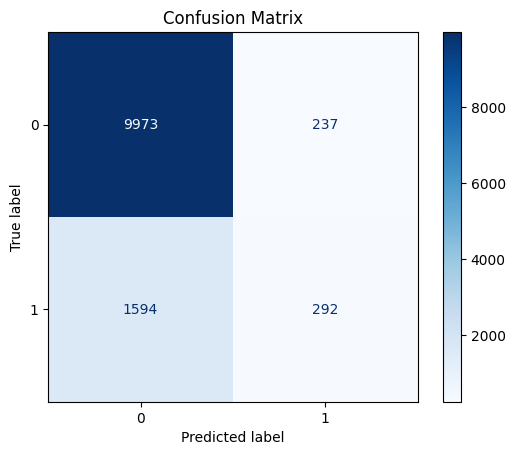

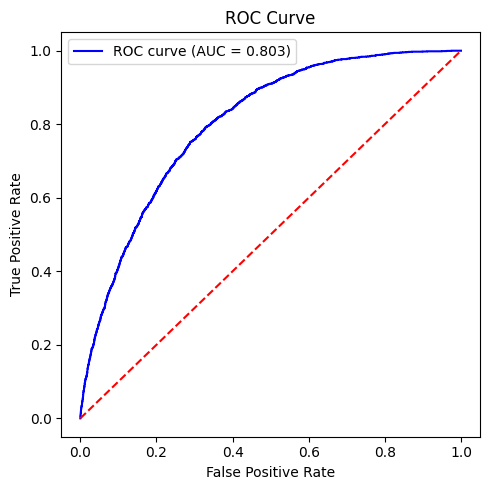

In [9]:
# -----------------------------
# Check Accuracy
# -----------------------------

# Prediction
y_pred_prob = logit_model.predict(X_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc = roc_auc_score(y, y_pred_prob)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Interaction Terms 1 (BMI x Age), (BMI x Sex)

**BMI × Age**
- Older individuals with higher BMI may have a disproportionately higher risk of diabetes compared to younger individuals with the same BMI.
- Interaction captures the synergistic effect of age and obesity on diabetes risk.

**BMI × Sex**
- The impact of BMI on diabetes risk may differ between males and females.
- For example, men and women may store fat differently, leading to sex-specific metabolic effects.

In [10]:
# -----------------------------
# Interaction Terms
# -----------------------------
X['BMI_Age'] = X['BMI'] * X['age']       
X['BMI_Sex'] = X['BMI'] * X['sex']    
     
X_const = sm.add_constant(X)

# -----------------------------
# GLM
# -----------------------------
logit_model = sm.GLM(y, X_const, family=sm.families.Binomial()).fit()
print("\n=== Logistic Regression Results ===")
logit_summary = summarize(logit_model)
print(logit_summary)


=== Logistic Regression Results ===
                                       coef   std err      z  P>|z|
const                             -5.753100  0.668000 -8.617  0.000
healthcare_provider                0.738800  0.143000  5.177  0.000
difficulty_affording_doc           0.299800  0.107000  2.815  0.005
exercise                          -0.242200  0.063000 -3.862  0.000
heart_attack                       0.224700  0.103000  2.177  0.029
heart_disease                      0.354500  0.097000  3.664  0.000
stroke                             0.226900  0.103000  2.211  0.027
asthma_ever                        0.077900  0.078000  0.993  0.321
skin_cancer                       -0.088300  0.095000 -0.933  0.351
other_cancer                       0.039500  0.078000  0.507  0.612
lung_diseases                     -0.063300  0.092000 -0.690  0.490
kidney_diseases                    0.711600  0.096000  7.385  0.000
arthritis                          0.072800  0.062000  1.176  0.240
married    

# Interaction Terms 2 (Smoker × Alcohol Consumption)

**Smoker × HvyAlcoholConsump**
- Smoking and heavy alcohol consumption often co-occur and may jointly increase diabetes risk more than each factor alone.
- Interaction captures the combined lifestyle effect on metabolic health.

In [11]:
# -----------------------------
# Interaction Terms
# -----------------------------
X['Smoker_HvyAlcoholConsump'] = X['non_smoker'] * X['drinker']            

X_const = sm.add_constant(X)

# -----------------------------
# GLM
# -----------------------------
logit_model = sm.GLM(y, X_const, family=sm.families.Binomial()).fit()
print("\n=== Logistic Regression Results ===")
logit_summary = summarize(logit_model)
print(logit_summary)


=== Logistic Regression Results ===
                                       coef   std err      z  P>|z|
const                             -5.758300  0.668000 -8.623  0.000
healthcare_provider                0.738800  0.143000  5.177  0.000
difficulty_affording_doc           0.299800  0.107000  2.815  0.005
exercise                          -0.242200  0.063000 -3.862  0.000
heart_attack                       0.224900  0.103000  2.179  0.029
heart_disease                      0.354200  0.097000  3.661  0.000
stroke                             0.227000  0.103000  2.212  0.027
asthma_ever                        0.078200  0.078000  0.998  0.318
skin_cancer                       -0.087800  0.095000 -0.928  0.353
other_cancer                       0.039300  0.078000  0.504  0.614
lung_diseases                     -0.062100  0.092000 -0.677  0.498
kidney_diseases                    0.711700  0.096000  7.386  0.000
arthritis                          0.072800  0.062000  1.175  0.240
married    

# Interaction Terms 3 (Exercise × BMI)

**PhysActivity × BMI**
- Physical activity may mitigate the risk associated with high BMI.
- Interaction reflects that the protective effect of exercise could differ depending on an individual’s BMI.

In [12]:
# -----------------------------
# Interaction Terms
# -----------------------------
X['PhysActivity_BMI'] = X['exercise'] * X['BMI']  

X_const = sm.add_constant(X)

# -----------------------------
# GLM
# -----------------------------
logit_model = sm.GLM(y, X_const, family=sm.families.Binomial()).fit()
print("\n=== Logistic Regression Results ===")
logit_summary = summarize(logit_model)
print(logit_summary)



=== Logistic Regression Results ===
                              coef   std err      z  P>|z|
const                    -5.334700  0.700000 -7.621  0.000
healthcare_provider       0.741400  0.143000  5.197  0.000
difficulty_affording_doc  0.292800  0.106000  2.750  0.006
exercise                 -0.791700  0.269000 -2.939  0.003
heart_attack              0.218900  0.103000  2.119  0.034
...                            ...       ...    ...    ...
no_HS_diploma             0.084400  0.124000  0.682  0.495
BMI_Age                   0.000008  0.000003  3.231  0.001
BMI_Sex                   0.000100  0.000087  1.198  0.231
Smoker_HvyAlcoholConsump -0.052700  0.119000 -0.444  0.657
PhysActivity_BMI          0.000200  0.000086  2.095  0.036

[61 rows x 4 columns]


# Removing variables with large p-values

In [13]:
import statsmodels.api as sm
import pandas as pd

# X: feature dataframe
# y: target series

X_columns = X.columns.tolist()

# Stepwise backward elimination
while True:
    X_current = X[X_columns]
    X_const = sm.add_constant(X_current)

    logit_model = sm.GLM(y, X_const, family=sm.families.Binomial()).fit()
    
    p_values = logit_model.pvalues.drop('const')
    max_p_value = p_values.max()
    
    if max_p_value > 0.05:
        feature_to_remove = p_values.idxmax()
        print(f"Removing feature '{feature_to_remove}' with p-value {max_p_value:.4f}")
        
        X_columns.remove(feature_to_remove)
    else:
        break

Removing feature 'dentist_Past_Year' with p-value 0.9920
Removing feature 'deaf' with p-value 0.9668
Removing feature 'non_smoker' with p-value 0.9044
Removing feature '6_or_more_teeth_removed' with p-value 0.8765
Removing feature 'employed' with p-value 0.8609
Removing feature 'dentist_Never' with p-value 0.8391
Removing feature 'sex' with p-value 0.8278
Removing feature 'all_teeth_removed' with p-value 0.8046
Removing feature 'dentist_Past_2_Years' with p-value 0.7589
Removing feature 'memory_trouble' with p-value 0.7234
Removing feature 'checkup_More_Than_5_Years' with p-value 0.6842
Removing feature 'race_native' with p-value 0.6471
Removing feature 'other_cancer' with p-value 0.6260
Removing feature 'lack_of_transport_to_medical_appt' with p-value 0.6032
Removing feature 'Smoker_HvyAlcoholConsump' with p-value 0.5645
Removing feature 'race_white' with p-value 0.5250
Removing feature 'lung_diseases' with p-value 0.4837
Removing feature 'age' with p-value 0.4715
Removing feature 'BM

# Predection with threshold 0.5


=== Final Logistic Regression Results ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Diabetes   No. Observations:                12096
Model:                            GLM   Df Residuals:                    12074
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4264.6
Date:                Wed, 26 Nov 2025   Deviance:                       8529.2
Time:                        11:02:16   Pearson chi2:                 1.08e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1483
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

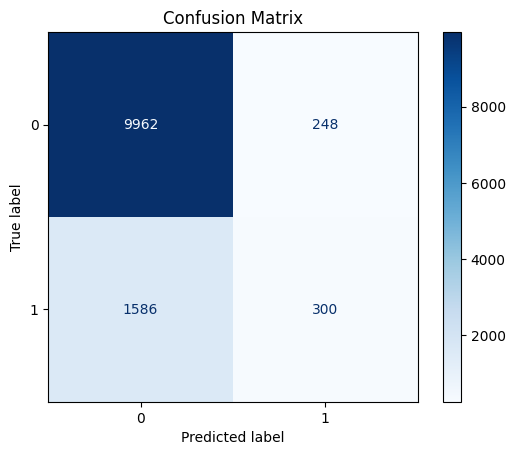


=== Classification Metrics ===
Accuracy : 0.8484
Precision: 0.5474
Recall   : 0.1591
F1-score : 0.2465


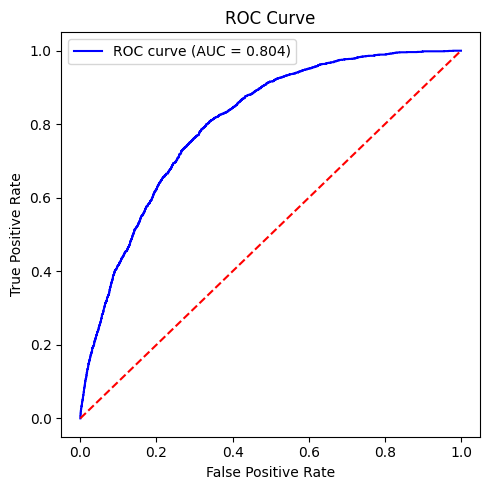

In [14]:
X_final = X[X_columns]
X_final_const = sm.add_constant(X_final)
final_model = sm.GLM(y, X_final_const, family=sm.families.Binomial()).fit()

print("\n=== Final Logistic Regression Results ===")
print(final_model.summary())

y_pred_prob = final_model.predict(X_final_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y, y_pred_class)
recall = recall_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
accuracy = accuracy_score(y, y_pred_class)

print("\n=== Classification Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc = roc_auc_score(y, y_pred_prob)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Predection with threshold 0.3


=== Final Logistic Regression Results ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Diabetes   No. Observations:                12096
Model:                            GLM   Df Residuals:                    12074
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4264.6
Date:                Wed, 26 Nov 2025   Deviance:                       8529.2
Time:                        11:02:16   Pearson chi2:                 1.08e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1483
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

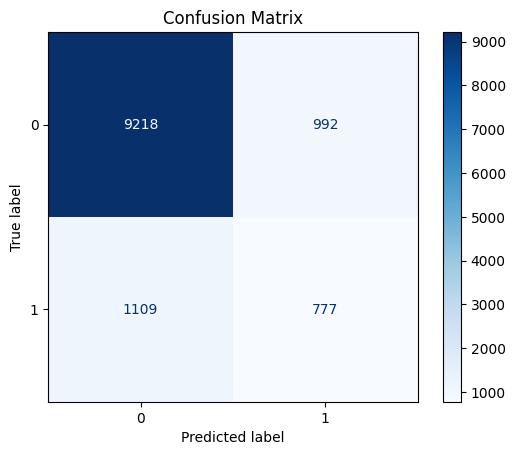


=== Classification Metrics ===
Accuracy : 0.8263
Precision: 0.4392
Recall   : 0.4120
F1-score : 0.4252


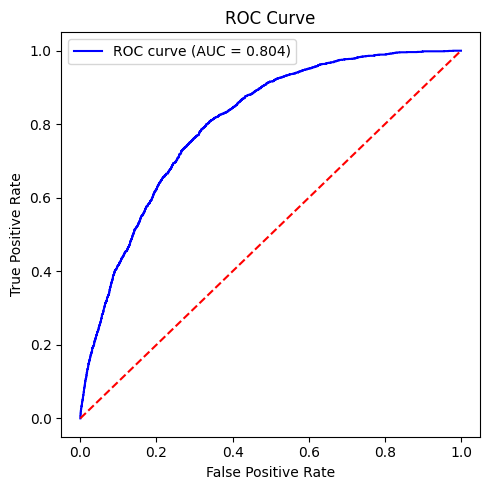

In [15]:

X_final = X[X_columns]
X_final_const = sm.add_constant(X_final)
final_model = sm.GLM(y, X_final_const, family=sm.families.Binomial()).fit()

print("\n=== Final Logistic Regression Results ===")
print(final_model.summary())

y_pred_prob = final_model.predict(X_final_const)
y_pred_class = (y_pred_prob >= 0.3).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y, y_pred_class)
recall = recall_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
accuracy = accuracy_score(y, y_pred_class)

print("\n=== Classification Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


# ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc = roc_auc_score(y, y_pred_prob)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# OverSampling (SMOTE) + Removing high p-value + threshold of 0.3

Removing feature 'BMI' with p-value 0.9744066695054119
Removing feature 'all_teeth_removed' with p-value 0.9537540261777555
Removing feature 'BMI_Sex' with p-value 0.9084172695093676
Removing feature 'dentist_More_Than_5_Years' with p-value 0.9040282060271253
Removing feature 'no_HS_diploma' with p-value 0.844810289071803
Removing feature 'household_income' with p-value 0.7778922790858891
Removing feature 'current_heavy_smoker' with p-value 0.7710401861578315
Removing feature 'age' with p-value 0.7071409698374295
Removing feature 'race_white' with p-value 0.697765091265449
Removing feature 'dentist_Past_2_Years' with p-value 0.6214924985074786
Removing feature 'dentist_Never' with p-value 0.40947400108290166
Removing feature 'trouble_getting_dressed' with p-value 0.39657831671270505
Removing feature 'non_smoker' with p-value 0.33113276512375445
Removing feature 'checkup_More_Than_5_Years' with p-value 0.3012591367764397
Removing feature 'veteran' with p-value 0.2501849076662207
Removin

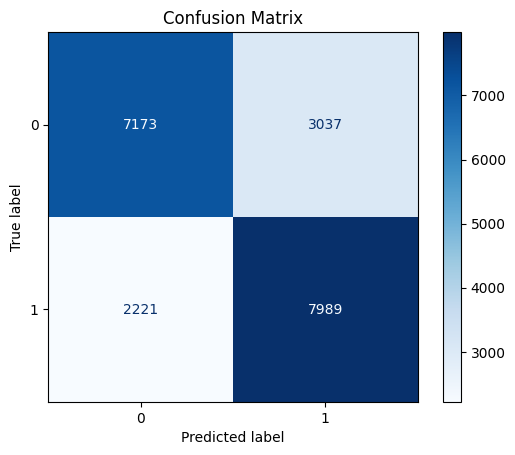


=== Classification Metrics (SMOTE) ===
Accuracy : 0.7425
Precision: 0.7246
Recall   : 0.7825
F1-score : 0.7524


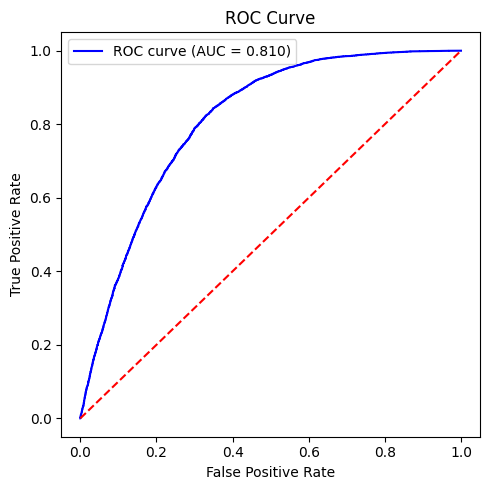

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 1. Standardize features (optional but recommended for SMOTE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 2. Apply SMOTE to oversample the minority class (y=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Convert back to DataFrame for statsmodels
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.Series(y_res)

# 3. Iterative p-value-based feature selection
X_final = X_res.copy()
while True:
    X_const = sm.add_constant(X_final)
    logit_model = sm.GLM(y_res, X_const, family=sm.families.Binomial()).fit()
    
    # Find the feature with the highest p-value (excluding constant)
    p_values = logit_model.pvalues.drop('const')
    max_p_value = p_values.max()
    
    # If the highest p-value > 0.05, remove the feature
    if max_p_value > 0.05:
        feature_to_remove = p_values.idxmax()
        print(f"Removing feature '{feature_to_remove}' with p-value {max_p_value}")
        X_final = X_final.drop(feature_to_remove, axis=1)
    else:
        break

# 4. Final logistic regression
X_final_const = sm.add_constant(X_final)
final_model = sm.GLM(y_res, X_final_const, family=sm.families.Binomial()).fit()
print("\n=== Final Logistic Regression Results ===")
print(final_model.summary())

# 5. Predictions
y_pred_prob = final_model.predict(X_final_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Threshold can be adjusted

# 6. Confusion Matrix
cm = confusion_matrix(y_res, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 7. Classification Metrics
precision = precision_score(y_res, y_pred_class)
recall = recall_score(y_res, y_pred_class)
f1 = f1_score(y_res, y_pred_class)
accuracy = accuracy_score(y_res, y_pred_class)

print("\n=== Classification Metrics (SMOTE) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


# 8. ROC Curve
fpr, tpr, thresholds = roc_curve(y_res, y_pred_prob)  # use y_res instead of y
auc = roc_auc_score(y_res, y_pred_prob)               # use y_res instead of y

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()